# setup

In [2]:
%load_ext autoreload
%autoreload 2

In [52]:
import os
import re
import pickle
import random
from typing import Sequence, Tuple
from tempfile import mkdtemp

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, Pool


pd.set_option('display.max_rows', 100)

In [124]:
from src.io import csv_loader_factory, PickleLoader
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder
from src.eval.metrics import compute_metrics

# load raw 

In [5]:
loader = csv_loader_factory('poleval')
data = loader.load()

INFO:2022-01-07 20:18:28:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-07 20:18:28:io:loaded 11039 rows


# base eda

In [9]:
data.shape

(11039, 3)

In [10]:
data.head()

,dataset,text_raw,tag
0,train,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,train,@anonymized_account @anonymized_account Brawo ...,0
2,train,"@anonymized_account @anonymized_account Super,...",0
3,train,@anonymized_account @anonymized_account Musi. ...,0
4,train,"Odrzut natychmiastowy, kwaśna mina, mam problem",0


In [11]:
data.groupby('dataset').agg(
    size=('text_raw', 'size'),
    target=('tag', 'mean')
)

,size,target
dataset,,
test,999,0.134134
train,10040,0.084761


# catboost on raw data

## prep data

In [11]:
train_df = data.loc[data['dataset']=='train', ['text_raw']]
train_label = data.loc[data['dataset']=='train', 'tag']
test_df = data.loc[data['dataset']=='test', ['text_raw']]
test_label = data.loc[data['dataset']=='test', 'tag']

train_pool = Pool(train_df, label=train_label, text_features=['text_raw'])
test_pool = Pool(test_df, label=test_label, text_features=['text_raw'])

## train model

In [126]:
params = {
    'eval_metric': 'AUC',
    'text_features': ['text_raw'],
    'metric_period': 10,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_df, y=train_label, eval_set=(test_df, test_label))

Learning rate set to 0.056019
0:	test: 0.5014365	best: 0.5014365 (0)	total: 61.7ms	remaining: 1m 1s
10:	test: 0.5131913	best: 0.5131913 (10)	total: 889ms	remaining: 1m 19s
20:	test: 0.5186351	best: 0.5186351 (20)	total: 1.79s	remaining: 1m 23s
30:	test: 0.4834613	best: 0.5186351 (20)	total: 2.7s	remaining: 1m 24s
40:	test: 0.4758347	best: 0.5186351 (20)	total: 3.56s	remaining: 1m 23s
50:	test: 0.4915581	best: 0.5186351 (20)	total: 4.38s	remaining: 1m 21s
60:	test: 0.4897205	best: 0.5186351 (20)	total: 5.23s	remaining: 1m 20s
70:	test: 0.5039039	best: 0.5186351 (20)	total: 6.13s	remaining: 1m 20s
80:	test: 0.5076827	best: 0.5186351 (20)	total: 7.03s	remaining: 1m 19s
90:	test: 0.5137520	best: 0.5186351 (20)	total: 7.85s	remaining: 1m 18s
100:	test: 0.5117289	best: 0.5186351 (20)	total: 8.72s	remaining: 1m 17s
110:	test: 0.4997239	best: 0.5186351 (20)	total: 9.54s	remaining: 1m 16s
120:	test: 0.4966396	best: 0.5186351 (20)	total: 10.3s	remaining: 1m 15s
130:	test: 0.5024933	best: 0.51863

## summ

,train,test
AUC,0.560178,0.518635
Accuracy,0.834761,0.802803
F1,0.023543,0.075117
Precision,0.023585,0.101266
Recall,0.023502,0.059701


|mean pred |0.158266|0.158236|


<AxesSubplot:ylabel='Frequency'>

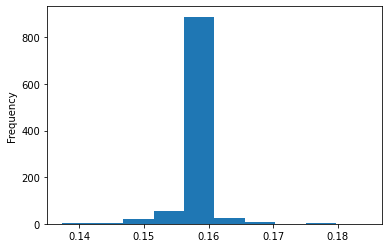

In [134]:
proba_train = cb.predict_proba(train_df)[:, 1]
proba_test = cb.predict_proba(test_df)[:, 1]

display(compute_metrics((train_label, proba_train), (test_label, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

# catboost on cleaned

## prep data

In [135]:
cleaner = TextCleaner()
cleaner.get_params()

{'clean_email': True,
 'clean_emoji': True,
 'clean_hashtag': True,
 'clean_non_alpha': True,
 'clean_non_letter': True,
 'clean_url': True,
 'clean_user_ref': True,
 'drop_repeated': True,
 'latinize': True,
 'to_lower': True}

In [136]:
train_clean = cleaner.fit_transform(train_df['text_raw'])
train_clean = pd.DataFrame(train_clean, columns=['text_clean'])


test_clean = cleaner.transform(test_df['text_raw'])
test_clean = pd.DataFrame(test_clean, columns=['text_clean'])


train_pool_clean = Pool(train_clean, label=train_label, text_features=['text_clean'])
test_pool_clean = Pool(test_clean, label=test_label, text_features=['text_clean'])

## train model

In [146]:
params = {
    'eval_metric': 'AUC',
    'text_features': ['text_clean'],
    'verbose': 10,
    'early_stopping_rounds': 30
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_clean, y=train_label, eval_set=(test_clean, test_label))

Learning rate set to 0.056019
0:	test: 0.4994220	best: 0.4994220 (0)	total: 59.4ms	remaining: 59.3s
10:	test: 0.5094427	best: 0.5094427 (10)	total: 791ms	remaining: 1m 11s
20:	test: 0.4975153	best: 0.5094427 (10)	total: 1.75s	remaining: 1m 21s
30:	test: 0.4803080	best: 0.5094427 (10)	total: 2.56s	remaining: 1m 20s
40:	test: 0.4903977	best: 0.5094427 (10)	total: 3.42s	remaining: 1m 20s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.509442671
bestIteration = 10

Shrink model to first 11 iterations.


## summ

,train,test
AUC,0.526524,0.509443
Accuracy,0.858765,0.823824
F1,0.041892,0.073684
Precision,0.049285,0.125000
Recall,0.036428,0.052239


|mean pred |0.24648|0.246439|


<AxesSubplot:ylabel='Frequency'>

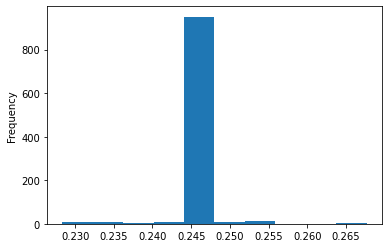

In [147]:
proba_train = cb.predict_proba(train_clean)[:, 1]
proba_test = cb.predict_proba(test_clean)[:, 1]

display(compute_metrics((train_label, proba_train), (test_label, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

<AxesSubplot:ylabel='Frequency'>

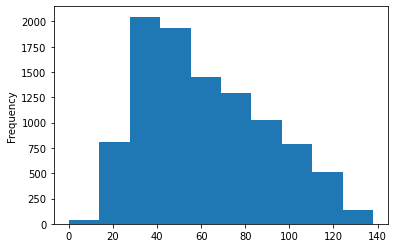

In [250]:
pd.Series(map(len, train_clean['text_clean'])).plot.hist()

In [249]:
pd.Series(map(len, train_clean['text_clean'])).value_counts(dropna=False).sort_index()

0      14
2       2
7       1
9       1
10      2
       ..
134     4
135     5
136     7
137     1
138     1
Length: 133, dtype: int64

<AxesSubplot:ylabel='Frequency'>

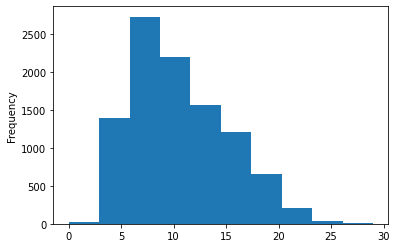

In [254]:
pd.Series(map(len, train_tokens)).plot.hist()

In [253]:
pd.Series(map(len, train_tokens)).value_counts().sort_index()

0       14
1        2
2        2
3       37
4      357
5     1004
6      974
7      911
8      848
9      761
10     767
11     676
12     549
13     540
14     477
15     463
16     408
17     345
18     280
19     209
20     165
21     110
22      62
23      34
24      22
25      11
26       3
27       4
28       4
29       1
dtype: int64

# w2v on cleaned

## prep data

In [138]:
# train
train_tokens = pd.Series(map(lambda text: text.split(), train_clean['text_clean']))
train_tokens.index = train_clean.index

train_tokens = train_tokens[(pd.Series(map(len, train_tokens))>0).values]
train_label_tok = train_label[train_tokens.index]


# test
test_tokens = pd.Series(map(lambda text: text.split(), test_clean['text_clean']))
test_tokens.index = test_clean.index

test_tokens = test_tokens[(pd.Series(map(len, test_tokens))>0).values]
test_label_tok = test_label[test_tokens.index]

In [139]:
emb = W2VEmbedder()
emb.get_params()

{'alpha': 0.025,
 'cbow_mean': 1,
 'epochs': 5,
 'hs': 0,
 'max_final_vocab': None,
 'min_alpha': 0.0001,
 'min_count': 5,
 'model_name': 'w2v',
 'negative': 5,
 'ns_exponent': 0.75,
 'sample': 0.001,
 'sg': 0,
 'vector_size': 20,
 'window': 5,
 'workers': 8}

In [18]:
emb.fit(train_tokens)

INFO:2022-01-07 20:20:36:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-07 20:20:36:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-07 20:20:37:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 21734 word types
INFO:2022-01-07 20:20:37:gensim.models.word2vec:collected 21764 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-07 20:20:37:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-07 20:20:37:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2518 unique words (11.56956441830546%% of original 21764, drops 19246)', 'datetime': '2022-01-07T20:20:37.039782', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-07 20:20:37:gensim.utils:Word2Vec lifecycle event {'msg': 'e

INFO:2022-01-07 20:20:37:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec(vocab=2518, vector_size=20, alpha=0.025)', 'datetime': '2022-01-07T20:20:37.320856', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


W2VEmbedder()

In [20]:
train_w2v = emb.transform(train_tokens)
test_w2v = emb.transform(test_tokens)

train_pool_w2v = Pool(train_w2v, label=train_label_tok)
test_pool_w2v = Pool(test_w2v, label=test_label_tok)

## train model

In [153]:
params = {
    'eval_metric': 'AUC',
    'early_stopping_rounds': 200,
    'verbose': 10,
}

cb = CatBoostClassifier(**params)
cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

Learning rate set to 0.056
0:	test: 0.4827582	best: 0.4827582 (0)	total: 7.08ms	remaining: 7.07s
10:	test: 0.5062203	best: 0.5152877 (3)	total: 69.7ms	remaining: 6.27s
20:	test: 0.4705159	best: 0.5152877 (3)	total: 131ms	remaining: 6.12s
30:	test: 0.4825166	best: 0.5152877 (3)	total: 196ms	remaining: 6.12s
40:	test: 0.4972694	best: 0.5152877 (3)	total: 262ms	remaining: 6.13s
50:	test: 0.4954620	best: 0.5152877 (3)	total: 324ms	remaining: 6.03s
60:	test: 0.4990424	best: 0.5152877 (3)	total: 386ms	remaining: 5.95s
70:	test: 0.4976922	best: 0.5152877 (3)	total: 450ms	remaining: 5.89s
80:	test: 0.4807264	best: 0.5152877 (3)	total: 512ms	remaining: 5.81s
90:	test: 0.4820119	best: 0.5152877 (3)	total: 574ms	remaining: 5.74s
100:	test: 0.4800017	best: 0.5152877 (3)	total: 636ms	remaining: 5.66s
110:	test: 0.4726167	best: 0.5152877 (3)	total: 700ms	remaining: 5.6s
120:	test: 0.4690277	best: 0.5152877 (3)	total: 761ms	remaining: 5.53s
130:	test: 0.4777414	best: 0.5152877 (3)	total: 825ms	remain

## summ

,train,test
AUC,0.551923,0.515249
Accuracy,0.859565,0.819820
F1,0.063830,0.072165
Precision,0.073282,0.116667
Recall,0.056537,0.052239


|mean pred |0.379661|0.379834|


<AxesSubplot:ylabel='Frequency'>

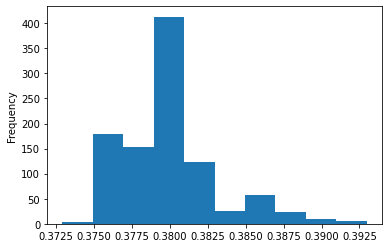

In [160]:
proba_train = cb.predict_proba(train_w2v)[:, 1]
proba_test = cb.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()

## svm

In [29]:
from sklearn.svm import SVC

In [34]:
clf = SVC(probability=True)

clf.fit(train_w2v, train_label_tok)

SVC(probability=True)

,train,test
AUC,0.500769,0.518670
Accuracy,0.846000,0.793794
F1,0.090695,0.096491
Precision,0.090695,0.117021
Recall,0.090695,0.082090


|mean pred |0.083677|0.083493|


<AxesSubplot:ylabel='Frequency'>

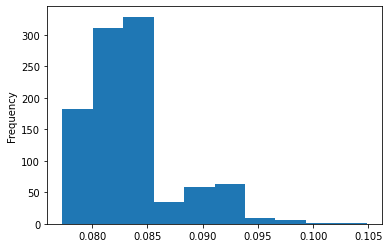

In [161]:
proba_train = clf.predict_proba(train_w2v)[:, 1]
proba_test = clf.predict_proba(test_w2v)[:, 1]

display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
pd.Series(proba_test).plot.hist()